In [5]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [6]:
import logging
import time
from pathlib import Path

import numpy as np
import polars as pl
import torch

from src.data.database_manager import DatabaseManager
from src.log_config import configure_logging
from src.models.data_loader import create_dataloaders
from src.models.data_preparation import prepare_data
from src.models.main_config import RANDOM_SEED
from src.models.utils import load_model
from src.plots.model_performance_per_participant import (
    analyze_per_participant,
    get_summary_statistics,
    plot_participant_performance,
)

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado", "filelock"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials

polars.config.Config

In [7]:
model, feature_list, sample_duration_ms, intervals, label_mapping, offsets_ms = (
    load_model(
        # "results/experiment_eda_raw_pupil_mean/model/PatchTST_20250730-175809.pt"
        # "results/experiment_eda_raw/model/PatchTST_20250730-222814.pt"
        # "results/experiment_eda_raw_pupil_mean/model/PatchTST_20250731-091436.pt"
        # "results/experiment_eda_raw_pupil_mean/model/PatchTST_20250804-134048.pt"
        # "results/experiment_eda_raw_pupil_mean/model/PatchTST_20250804-144005.pt"
        "results/experiment_eda_raw_pupil_mean/model/PatchTST_20250804-150402.pt"  # 7 s with plateaus, very nice
        # "results/experiment_eda_raw_pupil_mean/model/PatchTST_20250804-151623.pt"  # 5 s with plateaus,  0.73,  not so nice, model is quite unstable
    )
)
# Load data from database
db = DatabaseManager()
with db:
    df = db.get_table(
        "Merged_and_Labeled_Data",
        exclude_trials_with_measurement_problems=True,
    )

# Prepare data
X_train, y_train, X_val, y_val, X_train_val, y_train_val, X_test, y_test = prepare_data(
    df,
    feature_list,
    sample_duration_ms,
    RANDOM_SEED,
    intervals,
    label_mapping,
    offsets_ms,
)

test_groups = prepare_data(
    df, feature_list, sample_duration_ms, RANDOM_SEED, only_return_test_groups=True
)
_, test_loader = create_dataloaders(
    X_train_val, y_train_val, X_test, y_test, batch_size=64
)

10:26:17 | INFO    | utils | Using device: mps
10:26:17 | INFO    | utils | Loaded PatchTST model with test accuracy 0.77 to mps
10:26:17 | INFO    | utils | Input shape: (70, 2) | Features: ['eda_raw', 'pupil_mean'] | Sample duration: 7000 ms
10:26:17 | DEBUG   | utils | Intervals: {'increases': 'strictly_increasing_intervals', 'plateaus': 'plateau_intervals', 'decreases': 'major_decreasing_intervals'}
10:26:17 | DEBUG   | utils | Label mapping: {'increases': 0, 'plateaus': 0, 'decreases': 1}
10:26:17 | DEBUG   | utils | Offset ms: {'increases': 0, 'plateaus': 5000, 'decreases': 1000}
10:26:18 | DEBUG   | sample_creation | Removed 749 samples with less than 69 data points
10:26:18 | DEBUG   | data_preparation | Preparing data with sample duration 7000 ms and random seed 1337
10:26:18 | DEBUG   | data_preparation | Samples are based on intervals: {'increases': 'strictly_increasing_intervals', 'plateaus': 'plateau_intervals', 'decreases': 'major_decreasing_intervals'}
10:26:18 | DEBUG  

In [8]:
results_df = analyze_per_participant(
    model,
    test_loader,
    test_groups,
    threshold=0.50,
)
(
    results_df.remove(participant="overall")
    .sort("accuracy", descending=True)
    .get_column("participant")
    .to_list()
)

IndexError: boolean index did not match indexed array along axis 0; size of axis is 599 but size of corresponding boolean axis is 544

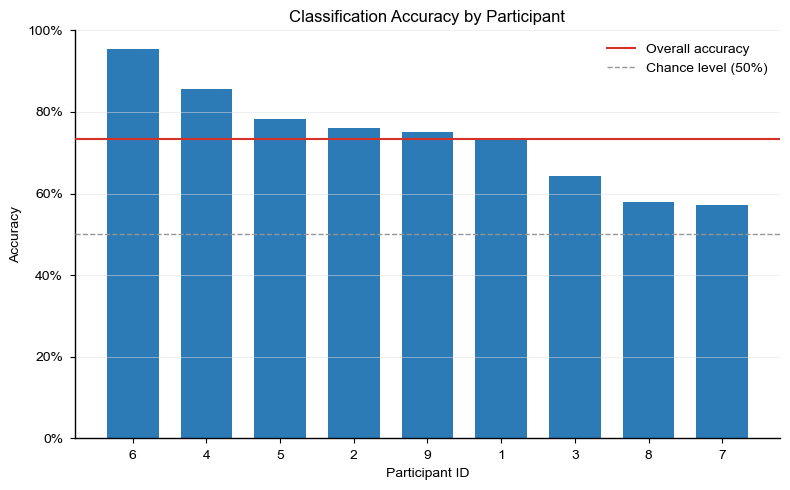

In [ ]:
model_performance_per_participant = plot_participant_performance(results_df)

In [21]:
summary_df = get_summary_statistics(results_df)

print("Summary of classification accuracy across participants")
print(summary_df)

Summary of classification accuracy across participants
shape: (5, 2)
┌─────────────────────────────────┬───────────────┐
│ Measure                         ┆ Value         │
│ ---                             ┆ ---           │
│ str                             ┆ str           │
╞═════════════════════════════════╪═══════════════╡
│ Overall accuracy                ┆ 73.4%         │
│ Participants above chance leve… ┆ 9 out of 9    │
│ Participants above overall acc… ┆ 5 out of 9    │
│ Highest accuracy (Participant … ┆ 95.5% (ID: 6) │
│ Lowest accuracy (Participant I… ┆ 57.1% (ID: 7) │
└─────────────────────────────────┴───────────────┘


In [22]:
# Save figure
FIGURE_DIR = Path("/Users/visser/drive/PhD/Papers/PAIN/figures")

model_performance_per_participant.savefig(
    FIGURE_DIR / "model_performance_per_participant.png", dpi=300, bbox_inches="tight"
)


## Inference time per sample

In [17]:
# Put model in evaluation mode
model.eval()

# Move to device first
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Compile the model
print("Compiling model...")
compiled_model = torch.compile(model)

# Get a single sample
single_sample, single_label = next(iter(test_loader))
single_sample = single_sample[:1].to(device)

# Warm-up runs (more important for compiled models)
print("Running warm-up...")
for _ in range(10):
    with torch.no_grad():
        _ = compiled_model(single_sample)

# Measure inference time for both compiled and original
num_runs = 100
times_original = []
times_compiled = []

# Test original model
for _ in range(num_runs):
    start_time = time.perf_counter()
    with torch.no_grad():
        _ = model(single_sample)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    times_original.append(time.perf_counter() - start_time)

# Test compiled model
for _ in range(num_runs):
    start_time = time.perf_counter()
    with torch.no_grad():
        _ = compiled_model(single_sample)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    times_compiled.append(time.perf_counter() - start_time)

# Compare results
print(f"\nInference time comparison (averaged over {num_runs} runs):")
print(f"Original model: {sum(times_original) / len(times_original) * 1000:.3f} ms")
print(f"Compiled model: {sum(times_compiled) / len(times_compiled) * 1000:.3f} ms")
print(f"Speedup: {sum(times_original) / sum(times_compiled):.2f}x")

Compiling model...
Running warm-up...

Inference time comparison (averaged over 100 runs):
Original model: 0.465 ms
Compiled model: 0.289 ms
Speedup: 1.61x
